In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy as sp
import scipy.interpolate
import scipy.signal
import scipy.stats

from PIL import Image
import scipy.io
from sklearn.preprocessing import normalize
import numpy.ma as ma
import math

from PIL import ImageFilter
from matplotlib import cm

In [2]:
def filelist(ID):
    return {'mask':"masks/ventricle_masks/mask"+str(ID)+"IDS.txt",
           'blowout':"masks/blowout_masks/mask"+str(ID)+"IDS_blowout.txt"}

def generate_mask(files, snr_mask):
    mask = {}
    mask['mask'] = np.loadtxt(files['mask'])
    mask['blowout_mask'] = np.loadtxt(files['blowout'])
    mask['snr_mask'] = snr_mask
    res = np.logical_and(~mask["blowout_mask"].astype(bool), mask['mask'])
    res = np.logical_and(res, mask["snr_mask"])
    return res

In [3]:
def load_recordings(filelist, CL_list):
    data = [CL_list, {}]
    for i, CL in enumerate(CL_list):
        data[1][CL] = sp.io.loadmat(filelist[i])
        data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
        width = data[1][CL]['cmosData'].shape[0] #get width
        height = data[1][CL]['cmosData'].shape[1] #get height
        data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    return data

def supersample(cmosData, fps, target_fps):
    length = cmosData.shape[2]
    end_time = int(np.round((length * 1000/fps)))
    time_n = int(end_time) + 1
    time_series = np.linspace(0, end_time, length)
    x = np.linspace(0, int(end_time), time_n)
    signal = sp.interpolate.interp1d(time_series, cmosData, axis = 2)
    return signal(x)

def ens_avg(cmosData, CL, cutoff):
    h = cmosData.shape[0]
    w = cmosData.shape[1]
    x = cmosData[:,:,cutoff:]
    center_point = (h//2, w//2)
    first_depol = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL]))
    res = np.zeros([200,200,CL])
    N = x.shape[2]//CL
    for i in range(N):
        shift = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL])) - first_depol
        #print(shift)
        shift = 0
        res += np.roll(x[:,:,i*CL:(i+1)*CL], -shift, axis = 2)
    res = res/N
    return res

def condition(data, cutoffs, corruption, CL, ens_avg_flag = True, sigma = 1.2):
    #data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
    width = data[1][CL].shape[0] #get width
    height = data[1][CL].shape[1] #get height
    #data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    data[1][CL][np.isnan(data[1][CL])]=0
    data[1][CL] = scipy.ndimage.gaussian_filter(data[1][CL],(sigma, sigma ,0), truncate = 2.0)
    data[1][CL] = supersample(data[1][CL], data[1]["frequency"], 1000)
    data[1][CL] = data[1][CL][:,:,:corruption[CL]]
    length = data[1][CL].shape[2] #?
    if ens_avg_flag:
        data[1][CL] = ens_avg(data[1][CL], CL, cutoffs[CL])
        length = CL
    smooth = scipy.ndimage.gaussian_filter(data[1][CL], (0,0,7))
    data[1][CL] = data[1][CL] - np.tile(np.reshape(smooth.min(axis = 2), (width, height, 1)), (1,1,length))
    data[1][CL] = np.divide(data[1][CL], np.tile(np.reshape(data[1][CL].max(axis = 2), (width, height, 1)), (1,1,length)), out=np.zeros_like(data[1][CL]), where=data[1][CL]!=0)
        
def APD80_map(data, CL):
    width = data.shape[0]
    height = data.shape[1]
    APD80 = np.zeros_like(data[:,:,0])
    time = np.linspace(0, CL-1, CL)
    for i in range(width):
        for j in range(height):
            if np.isnan(data[i,j,1]) or np.max(data[i,j,:]) < 0.2:
                APD80[i,j] = float('nan')
            else:
                if np.diff(np.where(data[i,j,:] <0.2)).size:
                    APD80[i,j] = np.max(np.diff(np.where(data[i,j,:] < 0.2)))
    return APD80

def apply_mask(data, mask):
    for CL in data[0]:
        mask = np.where(mask==0, float('nan'), mask)
        expanded_mask = np.repeat(np.expand_dims(mask, axis = 2), data[1][CL].shape[2], axis = 2)
        data[1][CL] = np.multiply(data[1][CL], expanded_mask)

def ventricle_mask(filename):
    mask_png = Image.open(filename)
    mask_array = np.array(mask_png)
    mask = mask_array[:,:,3] > 0.0
    return mask

In [4]:
#control:

CL_list_heart40 = [130,120,110,100,90,80]
filelist_heart40 = ["data/mouse_40_130ms_control_iDS.mat",
                   "data/mouse_40_120ms_control_iDS.mat",
                   "data/mouse_40_110ms_control_iDS.mat",
                   "data/mouse_40_100ms_control_iDS.mat",
                   "data/mouse_40_90ms_control_iDS.mat",
                   "data/mouse_40_80ms_control_iDS.mat"]
CL_list_heart41 = [150, 140, 130, 120]
filelist_heart41 = ["data/mouse_41_150ms_control_iDS.mat",
                   "data/mouse_41_140ms_control_iDS.mat",
                   "data/mouse_41_130ms_control_iDS.mat",
                   "data/mouse_41_120ms_control_iDS.mat"]
CL_list_heart45 = [150, 140, 130, 120, 110, 100, 90, 80]
filelist_heart45 = ["data/mouse_45_150ms_control_iDS.mat",
                   "data/mouse_45_140ms_control_iDS.mat",
                   "data/mouse_45_130ms_control_iDS.mat",
                   "data/mouse_45_120ms_control_iDS.mat",
                   "data/mouse_45_110ms_control_iDS.mat",
                   "data/mouse_45_100ms_control_iDS.mat",
                   "data/mouse_45_90ms_control_iDS.mat",
                   "data/mouse_45_80ms_control_iDS.mat"]
CL_list_heart46 = [150, 140, 130, 120, 110, 100, 90, 80]
filelist_heart46 = ["data/mouse_46_150ms_control_iDS.mat",
                   "data/mouse_46_140ms_control_iDS.mat",
                   "data/mouse_46_130ms_control_iDS.mat",
                   "data/mouse_46_120ms_control_iDS.mat",
                   "data/mouse_46_110ms_control_iDS.mat",
                   "data/mouse_46_100ms_control_iDS.mat",
                   "data/mouse_46_90ms_control_iDS.mat",
                   "data/mouse_46_80ms_control_iDS.mat"]
CL_list_heart31 = [150, 140]
filelist_heart31 = ["data/mouse_31_150ms_control_iDS.mat",
                   "data/mouse_31_140ms_control_iDS.mat"]
CL_list_heart62 = [150]
filelist_heart62 = ["data/mouse_62_150ms_control_iDS.mat"]
CL_list_heart2609 = [150]
filelist_heart2609 = ["data/mouse_2609_150ms_control_iDS.mat"]

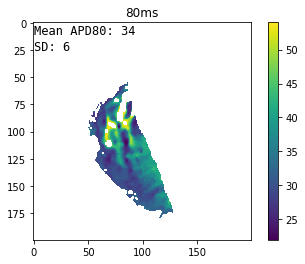

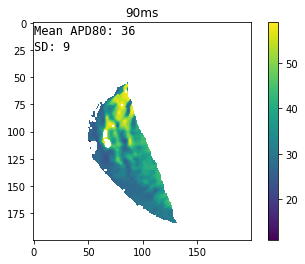

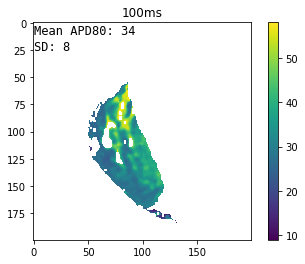

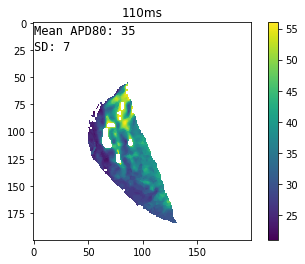

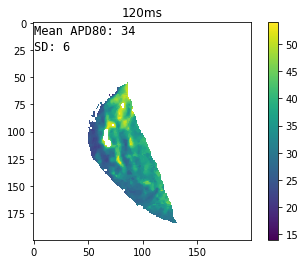

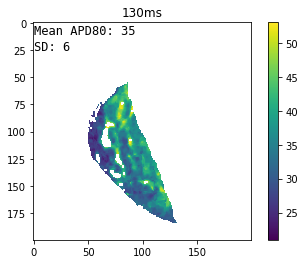

In [6]:
#control
heart40 = load_recordings(filelist_heart40, CL_list_heart40)
#frame = heart31[1][150]['cmosData'][:,:,0]
apply_mask(heart40, generate_mask(filelist(40), np.loadtxt("./snr_maps/control/iDS/SNR40.csv")>0.2))
heart40_cutoffs = {130:80, 120:50, 110:70, 100:0, 90:30, 80:30}
heart40_corruption = {130:None, 120:1750, 110:None, 100:None, 90:None, 80:None}
for CL in CL_list_heart40[::-1]:
    condition(heart40, heart40_cutoffs, heart40_corruption, CL)
    apply_mask(heart40, generate_mask(filelist(40), np.loadtxt("./snr_maps/control/iDS/SNR40.csv")>0.2))
    apdmap = APD80_map(heart40[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR40.csv")>0.2)

    RV_mask = ventricle_mask("masks/RV_masks/heart40_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart40_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1-LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

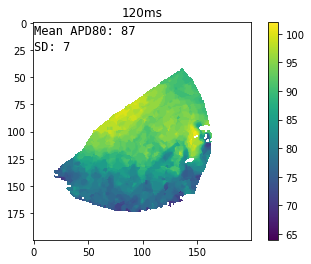

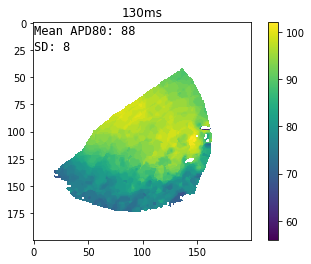

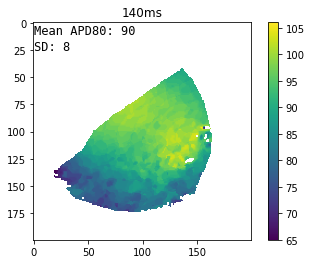

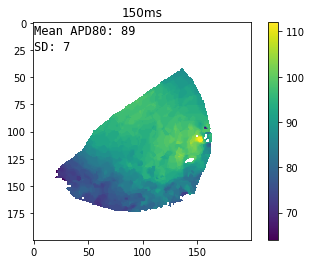

In [9]:
#control
heart41 = load_recordings(filelist_heart41, CL_list_heart41)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart41, generate_mask(filelist(41), np.loadtxt("./snr_maps/control/iDS/SNR41.csv")>0.3))
heart41_cutoffs = {150:50, 140:20, 130:65, 120:10}
heart41_corruption = {150:None, 140:None, 130:None, 120:None}
for CL in CL_list_heart41[::-1]:
    condition(heart41, heart41_cutoffs, heart41_corruption, CL, sigma = 2.0)
    apply_mask(heart41, generate_mask(filelist(41), np.loadtxt("./snr_maps/control/iDS/SNR41.csv")>0.3))
#     plt.plot(heart41[1][CL][100, 100, :])
#     plt.show()
    apdmap = APD80_map(heart41[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR41.csv")>0.4)

#     RV_mask = ventricle_mask("masks/RV_masks/heart41_iDS_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
#     LV_mask = ventricle_mask("masks/LV_masks/heart41_iDS_LV.png")
#     apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

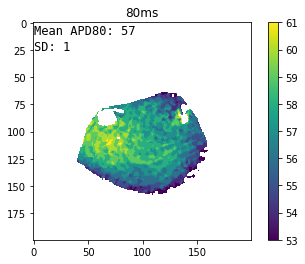

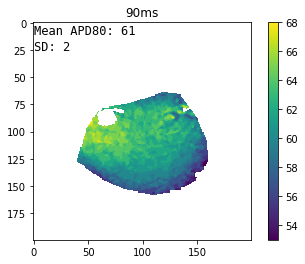

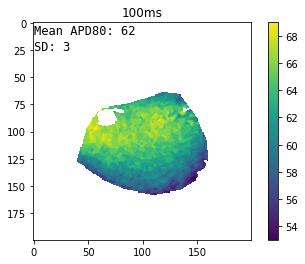

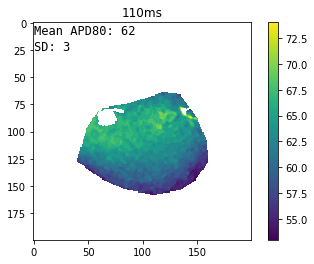

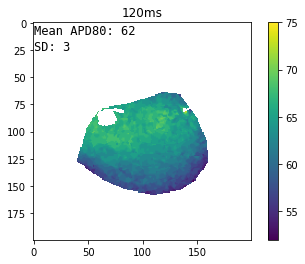

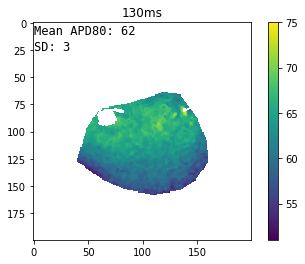

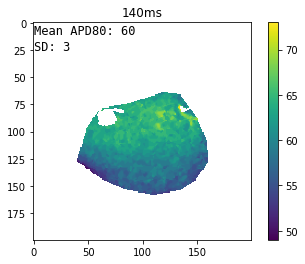

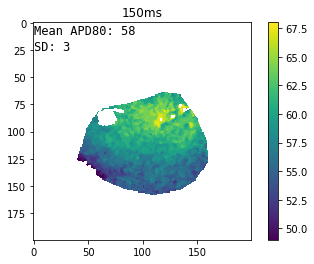

In [17]:
#control
heart45 = load_recordings(filelist_heart45, CL_list_heart45)
apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/control/iDS/SNR45.csv")>0.4))
heart45_cutoffs = {150:100, 140:10, 130:70,120:0,110:90,100:40,90:65,80:20}
heart45_corruption = {150:None, 140:None, 130:None,120:None,110:None,100:None,90:None,80:None}
for CL in CL_list_heart45[::-1]:
    condition(heart45, heart45_cutoffs, heart45_corruption, CL)
    apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/control/iDS/SNR45.csv")>0.4))
    apdmap = APD80_map(heart45[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR45.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart45_iDS_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
#     LV_mask = ventricle_mask("masks/LV_masks/heart45_iDS_LV.png")
#     apdmap = np.multiply(apdmap, 1-LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

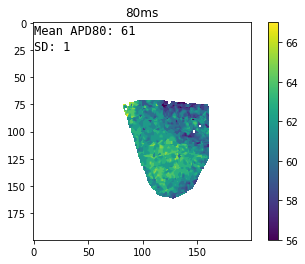

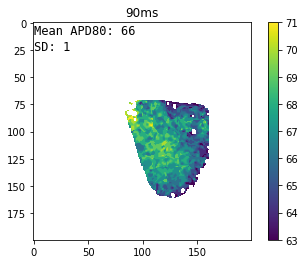

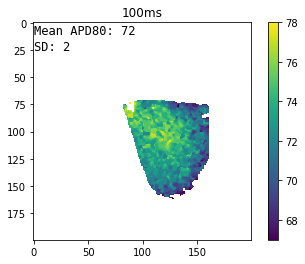

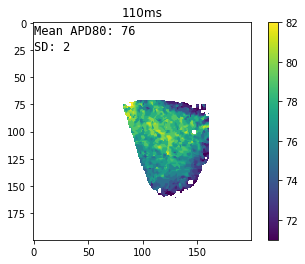

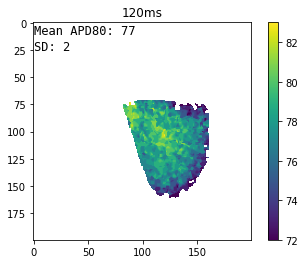

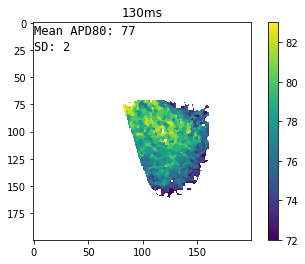

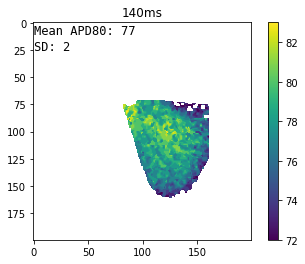

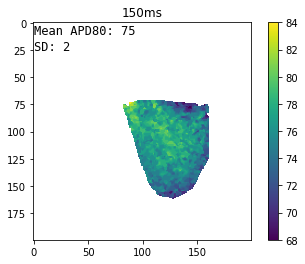

In [19]:
#control
heart46 = load_recordings(filelist_heart46, CL_list_heart46)
apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/control/IDS/SNR46.csv")>0.3))
heart46_cutoffs = {160:0, 150:20, 140:20, 130:0,120:40,110:0, 100:60, 90:10, 80:10}
heart46_corruption = {160:None, 150:None, 140:None, 130:1220,120:None,110:None,100:None, 90:None, 80:None}
for CL in CL_list_heart46[::-1]:
    condition(heart46, heart46_cutoffs, heart46_corruption, CL)
    apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/control/IDS/SNR46.csv")>0.3))
    apdmap = APD80_map(heart46[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR46.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart46_iDS_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart46_iDS_LV.png")
    apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

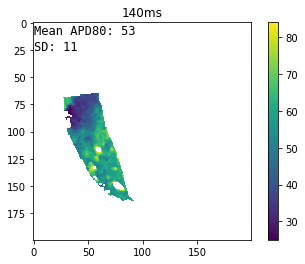

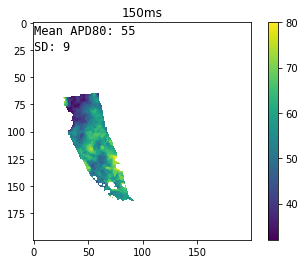

In [22]:
heart31 = load_recordings(filelist_heart31, CL_list_heart31)
#[200, 180, 170, 160, 150, 140, 130]
apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3))
heart31_cutoffs = {150:80, 140:110}
heart31_corruption = {150:None, 140:None}
for CL in CL_list_heart31[::-1]:
    condition(heart31, heart31_cutoffs, heart31_corruption, CL)
    apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3))
    apdmap = APD80_map(heart31[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR31.csv")>0.3)

    RV_mask = ventricle_mask("masks/RV_masks/heart31_iDS_RV.png")
    apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart31_iDS_LV.png")
    apdmap = np.multiply(apdmap, 1 - LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

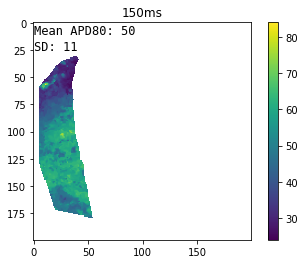

In [24]:
heart2609 = load_recordings(filelist_heart2609, CL_list_heart2609)
apply_mask(heart2609, generate_mask(filelist(2609), np.loadtxt("./snr_maps/control/iDS/SNR2609.csv")>0.1))
heart2609_cutoffs = {150:0}
heart2609_corruption = {150:None}
condition(heart2609, heart2609_cutoffs, heart2609_corruption, 150)
apply_mask(heart2609, generate_mask(filelist(2609), np.loadtxt("./snr_maps/control/iDS/SNR2609.csv")>0.1))
CL = 150
apdmap = APD80_map(heart2609[1][CL], CL)
apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR2609.csv")>0.1)

RV_mask = ventricle_mask("masks/RV_masks/heart2609_iDS_RV.png")
apdmap = np.multiply(apdmap, RV_mask)
LV_mask = ventricle_mask("masks/LV_masks/heart2609_iDS_LV.png")
apdmap = np.multiply(apdmap, 1 - LV_mask)

apdmap[apdmap == 0] = np.nan

iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

plt.figure()
plt.imshow(apdmap)
plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
plt.title("%dms"%CL)
plt.colorbar()
plt.show()

C:\Users\dmitry\miniconda3\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


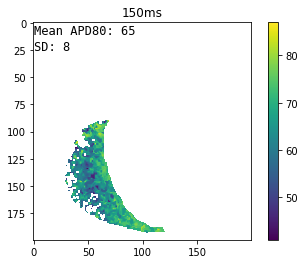

In [27]:
heart62 = load_recordings(filelist_heart62, CL_list_heart62)
apply_mask(heart62, generate_mask(filelist(62), np.loadtxt("./snr_maps/control/IDS/SNR62.csv")>0.12))
heart62_cutoffs = {150:0}
heart62_corruption = {150:None}
condition(heart62, heart62_cutoffs, heart62_corruption, 150)
apply_mask(heart62, generate_mask(filelist(62), np.loadtxt("./snr_maps/control/IDS/SNR62.csv")>0.12))
CL = 150
# plt.plot(heart62[1][150][100, 100, :])
apdmap = APD80_map(heart62[1][CL], CL)
apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/iDS/SNR62.csv")>0.12)

RV_mask = ventricle_mask("masks/RV_masks/heart62_iDS_RV.png")
apdmap = np.multiply(apdmap, RV_mask)
LV_mask = ventricle_mask("masks/LV_masks/heart62_iDS_LV.png")
apdmap = np.multiply(apdmap, 1 - LV_mask)

apdmap[apdmap == 0] = np.nan

iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

plt.figure()
plt.imshow(apdmap)
plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
plt.title("%dms"%CL)
plt.colorbar()
plt.show()